In [1]:
#use conda niwrap3912
import nibabel as nib
import ants
from ants.plotting import plot
import numpy as np


In [26]:

#data_path: Tian parcellation registered onto the (Ex Vivo) subject data
dat_path = '/Users/dennis.jungchildmind.org/Desktop/subcortical_test/I38_new_confidence/110625_from_t2_tian_masked/mywarpedimage.nii'
dat = nib.load(dat_path)
print(dat.get_fdata().shape)
print(np.unique(dat.get_fdata()).shape)
print(np.sum(dat.get_fdata()==10))
print(np.unique(dat.get_fdata()))



(77, 168, 192)
(209,)
2285
[  0.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.
  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.
  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199.

(193, 229, 193)
(44,)
11629
[  0.   2.   3.   4.   5.   7.   8.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  24.  26.  28.  30.  31.  41.  42.  43.  44.  46.  47.  49.
  50.  51.  52.  53.  54.  58.  60.  62.  63.  77.  85. 251. 252. 253.
 254. 255.]


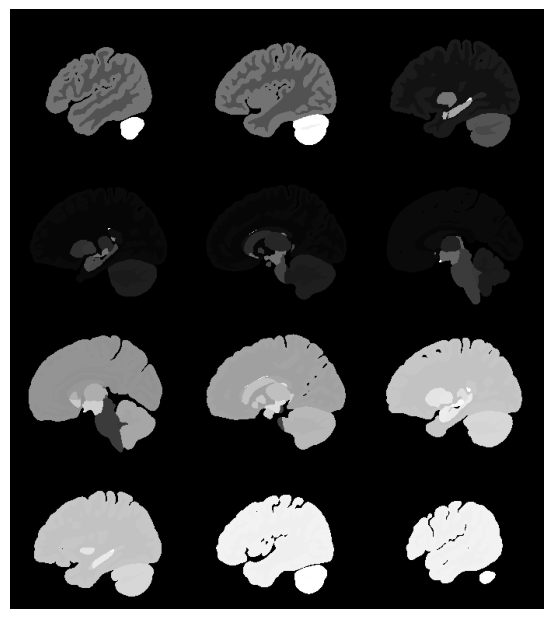

[  0.   2.   3.   4.   5.   7.   8.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  24.  26.  28.  30.  31.  41.  42.  43.  44.  46.  47.  49.
  50.  51.  52.  53.  54.  58.  60.  62.  63.  77.  85. 251. 252. 253.
 254. 255.]


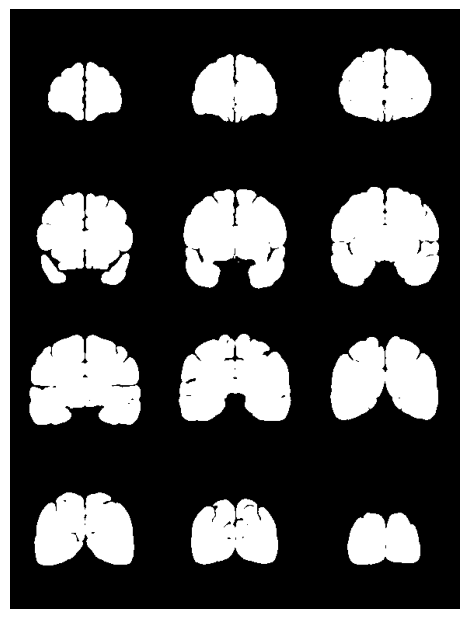

In [72]:
#generate mask for erebellum and brain-stem structures from the MNI152NLin2009cAsym
seg_aseg_path = '/Users/dennis.jungchildmind.org/Downloads/tpl-MNI152NLin2009cAsym_res-01_seg-aseg_dseg.nii'

seg_aseg_ants = ants.image_read(seg_aseg_path)
plot(seg_aseg_ants,axis=0)
#
right_cerebellum = [45,46,47]
left_cerebellum = [6,7,8]
other_structure = [15,16]#15: third ventricle, 16: brain-stem

tmp_np = seg_aseg_ants.numpy().flatten()
print(np.unique(tmp_np))
#remove right and left cerebellum, set to 0
tmp_np[np.isin(tmp_np, right_cerebellum)] = 0
tmp_np[np.isin(tmp_np, left_cerebellum)] = 0
tmp_np[np.isin(tmp_np, other_structure)] = 0
#convert back to ants image
# Reshape flat array back to original image shape before converting to ANTs image
tmp_np_reshaped = tmp_np.reshape(seg_aseg_ants.shape)
tmp_ants = ants.from_numpy(tmp_np_reshaped.astype(tmp_np.dtype),
                          origin=tmp.origin,
                          spacing=tmp.spacing,
                          direction=tmp.direction)
cerebellum_mask = tmp_ants>0
plot(cerebellum_mask,axis=1)

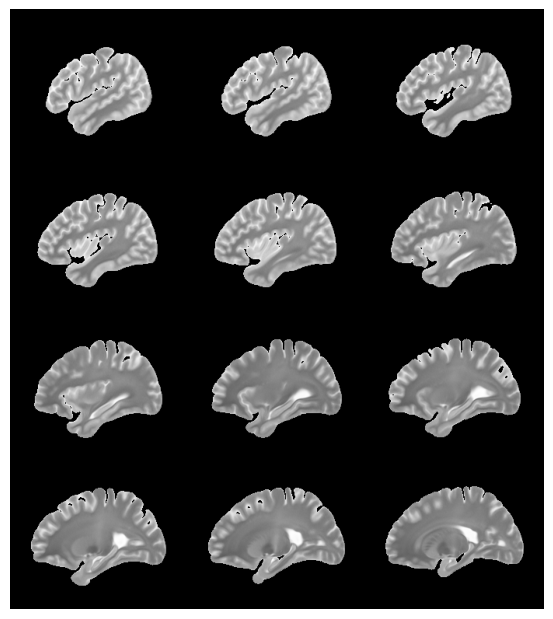

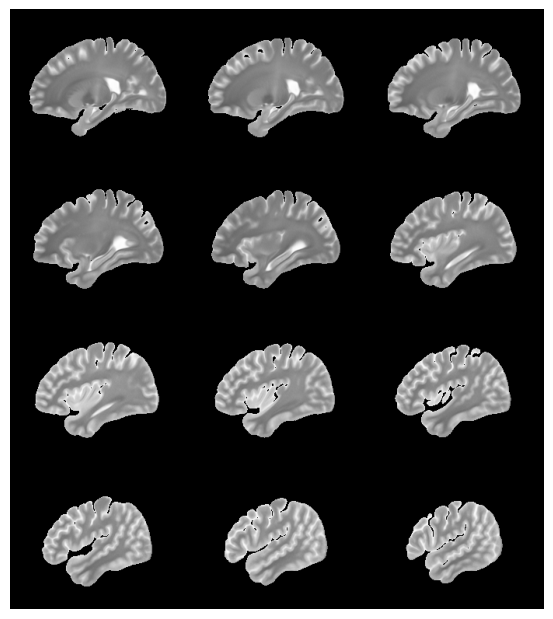

In [80]:
#apply the mask to the MNI152NLin2009cAsym template
template_path = '/Users/dennis.jungchildmind.org/Desktop/atlas/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_t2_tal_nlin_asym_09c.nii'
headmask_path = '/Users/dennis.jungchildmind.org/Desktop/atlas/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_t1_tal_nlin_asym_09c_mask.nii'#only has T1
template = ants.image_read(template_path)
headmask = ants.image_read(headmask_path)
masked_template = ants.mask_image(template, headmask,level=1,binarize=False)#this removes the skull right away
# Get numpy array
data = masked_template.numpy()

# Create left hemisphere mask
# In MNI space with ANTs, need to check orientation
center_x = data.shape[0] // 2
left_mask = np.zeros_like(data)
left_mask[:center_x, :, :] = 1

# Create ANTs image from mask
mask_img = ants.from_numpy(left_mask, origin=masked_template.origin, 
                           spacing=masked_template.spacing, direction=masked_template.direction)
left_hemisphere = masked_template * mask_img * cerebellum_mask
plot(left_hemisphere,axis=0)
# Save result
ants.image_write(left_hemisphere, 'mni_icbm152_t2_tal_nlin_asym_09c_left_hemi_no_cerebellum.nii')

#do for right hemisphere
right_mask = np.zeros_like(data)
right_mask[center_x:, :, :] = 1

mask_img = ants.from_numpy(right_mask, origin=masked_template.origin, 
                           spacing=masked_template.spacing, direction=masked_template.direction)

right_hemisphere = masked_template * mask_img * cerebellum_mask
plot(right_hemisphere,axis=0)
ants.image_write(right_hemisphere, 'mni_icbm152_t2_tal_nlin_asym_09c_right_hemi_no_cerebellum.nii')
